## introduction 

A million and a half people dying from Tuberculosis so, what is Tuberculosis?

Tuberculosis (TB) is a potentially serious infectious disease caused by a bacterium called Mycobacterium tuberculosis that usually attack the lungs  but it can affect any part of the body, including the tummy (abdomen), glands, bones and nervous system. The bacteria that cause tuberculosis are spread from person to person through tiny droplets released into the air via coughs and sneezes.

"When TB wakes up and gets into the lungs, it eats them from the inside out, slowly diminishing their capacity, causing the chest to fill up with blood and the liquidy remains of the lungs. A wet, hacking cough is evocative of TB. The lungs now in liquid form are sloshing around in the chest. Cough that up, even in microscopic, impossible to see droplets, near other people, and they have a very good chance of getting TB too.”

“Eventually, liquid replaces the lungs, the suffering patients cannot get enough oxygen, and respiratory failure occurs, they can no longer breathe and they drown. It’s painful, it’s drawn out. It’s an awful way to die. But before any of this happens the disease weakens you, diminishes your capacity for work, and puts your family and friends, and anyone else you come into contact with, at risk. Individual death is only part of the problem"[4].

Once rare in developed countries, tuberculosis infections began increasing in 1985, partly because of the emergence of HIV, the virus that causes AIDS. HIV weakens a person's immune system, so it can't fight the TB germs.


Although your body can harbor the bacteria that cause tuberculosis, your immune system usually can prevent you from becoming sick. For this reason, doctors make a distinction between:

- Latent TB: You have a TB infection, but the bacteria in your body are inactive and cause no symptoms. Latent TB, also called inactive TB or TB infection, isn't contagious. Latent TB can turn into active TB, so treatment is important.

- Active TB: Also called TB disease, this condition makes you sick and, in most cases, can spread to others. It can occur weeks or years after infection with the TB bacteria.[5]


So, we decided to work on a project to detect tuberculosis through x-rays of the chest, and as an addition, we will work on classifying the x-ray images, whether the patient has active tuberculosis or not.

### Our dataset

This dataset contains CXR images of Normal (3500) and patients with TB (700 TB images in publicly accessible and 2800 TB images can be downloaded from NIAID TB portal[3] by signing an agreement). 

The TB database is collected from the source:
- NLM dataset: National Library of Medicine (NLM) in the U.S. [1] has made two lung X-ray datasets publicly available: the Montgomery and Shenzhen datasets.
- Belarus dataset: Belarus Set [2] was collected for a drug resistance study initiated by the National Institute of Allergy and Infectious Diseases, Ministry of Health, Republic of Belarus.
- NIAID TB dataset: NIAID TB portal program dataset [3], which contains about 3000 TB positive CXR images from about 3087 cases.
- RSNA CXR dataset: RSNA pneumonia detection challenge dataset [4], which is comprised of about 30,000 chest X-ray images, where 10,000 images are normal and others are abnormal and lung opacity images.

This database has been used in the paper titled “Reliable Tuberculosis Detection using Chest X-ray with Deep Learning, Segmentation and Visualization” published in IEEE Access in 2020.

References:

[1] S. Jaeger, S. Candemir, S. Antani, Y.-X. J. Wáng, P.-X. Lu, and G. Thoma, "Two public chest X-ray datasets for computer-aided screening of pulmonary diseases," Quantitative imaging in medicine and surgery, vol. 4 (6), p. 475(2014)

[2] B. P. Health. (2020). BELARUS TUBERCULOSIS PORTAL [Online]. Available: http://tuberculosis.by/. [Accessed on 09-June-2020]

[3] NIAID TB portal program dataset [Online]. Available: https://tbportals.niaid.nih.gov/download-data.

[4]https://tbfacts.org/dying-tb/

[5]https://www.mayoclinic.org/diseases-conditions/tuberculosis/symptoms-causes/syc-20351250

## Data Exploration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [131]:
import cv2
import os

In [3]:
normal = pd.read_excel('TB_Chest_Radiography_Database/Normal.metadata.xlsx')
TB = pd.read_excel('TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx')

In [4]:
tbpath = 'TB_Chest_Radiography_Database/Tuberculosis/Tuberculosis-'
normalpath = 'TB_Chest_Radiography_Database/Normal/Normal-'

##### function for display the images

In [5]:
def show_image(path):
    
    image = cv2.imread(path)

    # switch red and blue color channels 
    # OpenCV assumes BLUE chanel comes first, not RED as in many images
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # plot the image
    fig = plt.figure(figsize=(9,9))
    plt.imshow(image)

##### function for reading images only

In [6]:
# read the images in case t = 1 then path of tb images will used other wise normal
def read_image(t,number):
    if t == 0:
        return cv2.imread(normalpath+ number +'.png')
    else:
        return cv2.imread(tbpath+ number +'.png')

## How can we determine the x-ray of tuberculosis from the x-ray of a healthy patient?
                    Chest has tuberculosis                      Healthy or Nomal chest
<img src='image.jpeg' width=70% height=70%/>

The chest with tuberculosis has more than one symptom, including but not limited to:

- Decreased lung volume
- The appearance of fibrous scars and bullous changes

<img src='image2.jpeg' width=70% height=70%/>

- Beaded shape trachea

<img src='image3.jpeg' width=70% height=70%/>

- Granuloma

<img src='image4.jpeg' width=40% height=40%/>

and much more:
<img src='image5.jpeg' width=40% height=40%/>

Refrences:
    https://www.youtube.com/watch?v=U7zvKbjYX7I

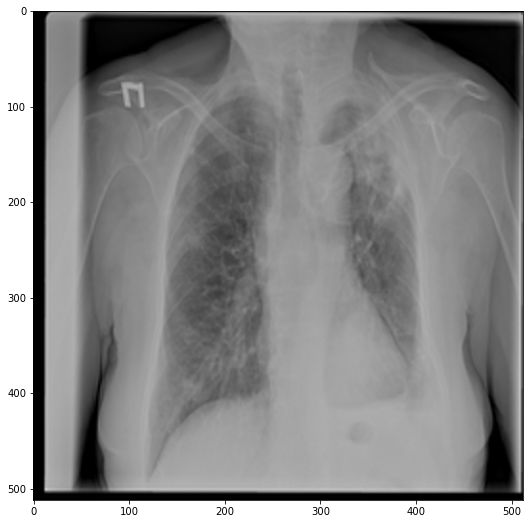

In [7]:
# chest with tuberculosis 
show_image(tbpath+'37.png')

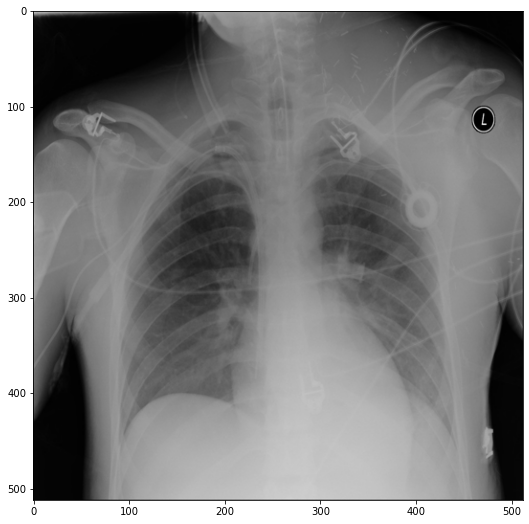

In [8]:
# chest without tuberculosis (Normal)
show_image(normalpath+'37.png')

## Data Preprocessing

#### We will use the cv2.calcHist function to plot our histograms of the images.
cv2.calcHist(images, channels, mask, histSize, ranges).

function parameter:
- images: This is the image that we want to compute a histogram for.

- channels: A list of indexes, where we specify the index of the channel we want to compute a histogram for. To compute a histogram of a grayscale image, the list would be [0]. To compute a histogram for all three red, green, and blue channels, the channels list would be [0, 1, 2].

- mask: Remember learning about masks in my Image Masking with OpenCV guide? Well, here we can supply a mask. If a mask is provided, a histogram will be computed for masked pixels only. If we do not have a mask or do not want to apply one, we can just provide a value of None.

- histSize: This is the number of bins we want to use when computing a histogram. Again, this is a list, one for each channel we are computing a histogram for. The bin sizes do not all have to be the same. Here is an example of 32 bins for each channel: [32, 32, 32].

- ranges: The range of possible pixel values. Normally, this is [0, 256] (that is not a typo — the ending range of the cv2.calcHist function is non-inclusive so you’ll want to provide a value of 256 rather than 255) for each channel, but if you are using a color space other than RGB [such as HSV], the ranges might be different.)

#### We will use also, Histograms Equalization.
cv2.equalizeHist()

OpenCV has a function to equalize the images. Its input is just grayscale image and output is our histogram equalized image.

## Normal

In [133]:
# first parameter (Normal class = 0 or tb class = 1 , number of the image)
img = read_image(0,'37')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

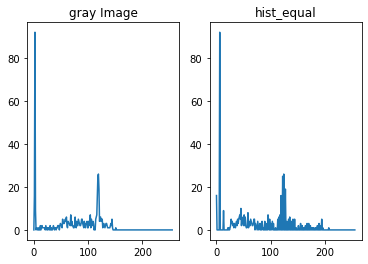

In [134]:
hist=cv2.calcHist(img,[0],None,[256],[0,256])
img_eqhist=cv2.equalizeHist(img)
hist1=cv2.calcHist(img_eqhist,[0],None,[256],[0,256])

plt.subplot(121)
plt.title("gray Image")
plt.plot(hist)
plt.subplot(122)
plt.title("hist_equal")
plt.plot(hist1)
plt.show()


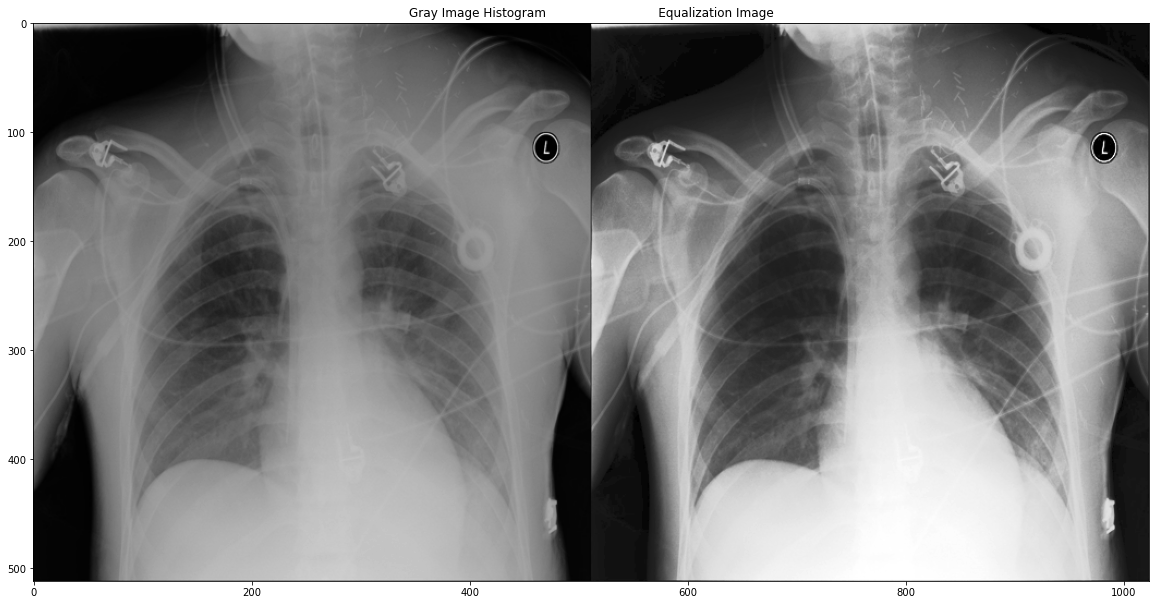

In [11]:
eqhist_images=np.concatenate((img,img_eqhist),axis=1)
plt.figure(figsize=(20,20))
plt.imshow(eqhist_images,cmap="gray")
plt.title('Gray Image Histogram                             Equalization Image')

plt.show()

## Tuberculosis (TB)

In [12]:
# first parameter (Normal class = 0 or tb class = 1 , number of the image)
img2 = read_image(1,'37')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

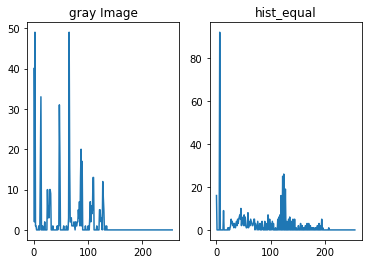

In [13]:
hist=cv2.calcHist(img2,[0],None,[256],[0,256])
img_eqhist2=cv2.equalizeHist(img2)
hist1=cv2.calcHist(img_eqhist,[0],None,[256],[0,256])

plt.subplot(121)
plt.title("gray Image")
plt.plot(hist)
plt.subplot(122)
plt.title("hist_equal")
plt.plot(hist1)
plt.show()


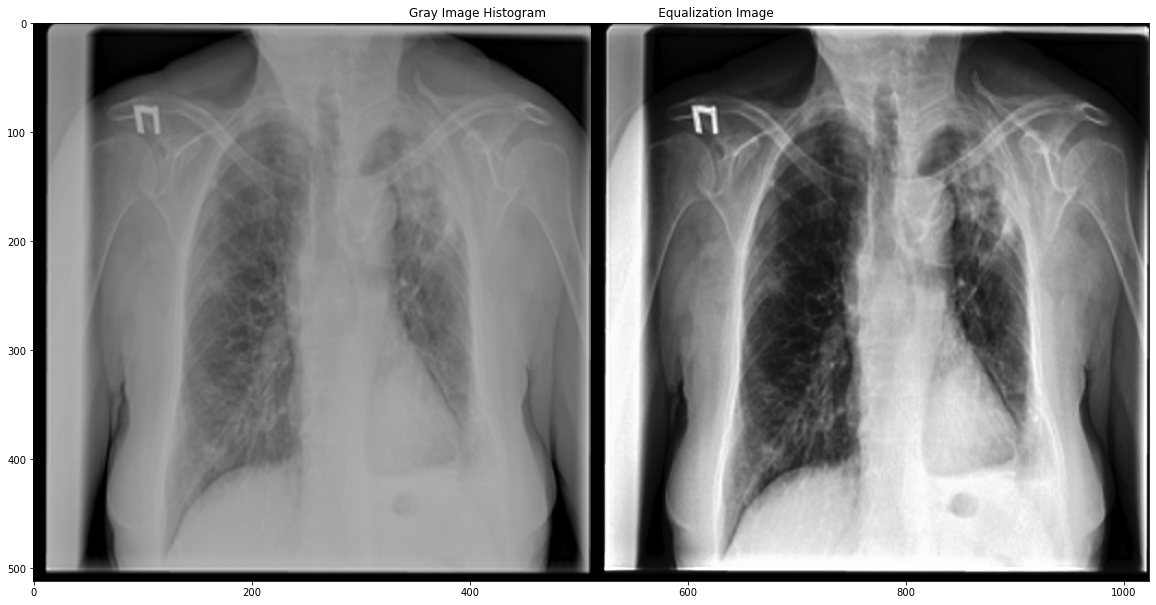

In [14]:
eqhist_images=np.concatenate((img2,img_eqhist2),axis=1)
plt.figure(figsize=(20,20))
plt.imshow(eqhist_images,cmap="gray")
plt.title('Gray Image Histogram                             Equalization Image')

plt.show()

Now we can see the difference between the two images. The histogram equalization works well when you focus on a specific area. The above equalization gives a good improvement but not the best because it's considering the global contrast of the image, as we can see in the upper right area of the chest x-ray the white lines, or as they are called lymph nodes have been softened, which we need to highlight to determine if the patient suffers from tuberculosis or not. So histogram equalization will not work well in places where there are large differences in density where the graph covers a large area.

To solve the histogram equalization problem we will use CLAHE(Contrast Limited Adaptive Histogram Equalization).
CLAHE divides the image into small regions called (tiles) to avoid the global contrast of the image and then applies the Histogram Equalization for each tile to enhance the contrast. if there's a noise in one of the tiles it will amplify. to avoid this problem OpenCV uses a contrast limit. "If any histogram bin is above the specified contrast limit, those pixels are clipped and distributed uniformly to other bins before applying histogram equalization. After equalization, to remove artifacts in tile borders, bilinear interpolation is applied".


function Parameters:
- clipLimit	Threshold for contrast limiting.
- tileGridSize	Size of grid for histogram equalization. Input image will be divided into equally sized rectangular tiles. tileGridSize defines the number of tiles in row and column.

https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html

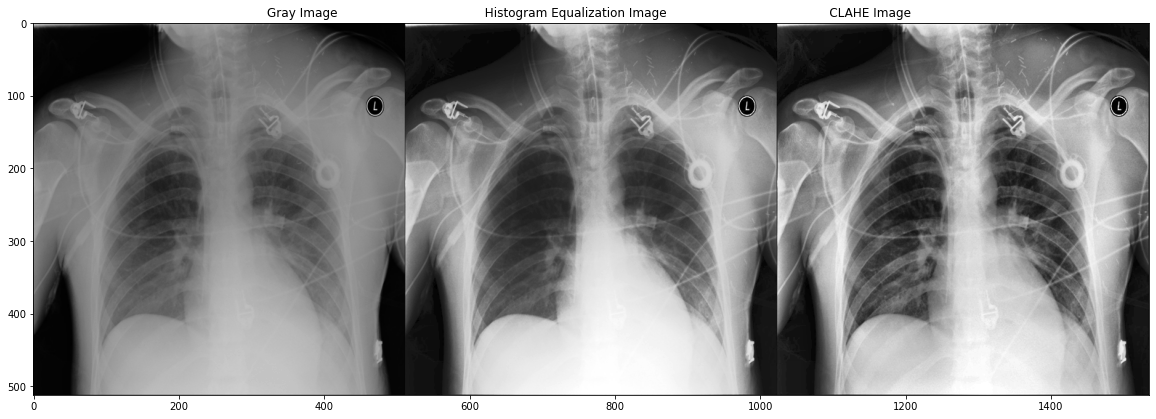

In [15]:
# Contrast Limited Adaptive Histogram Equalization for normal chest
clahe = cv2.createCLAHE(clipLimit=3).apply(img_eqhist)
images = np.concatenate((img, img_eqhist, clahe),axis=1)
plt.figure(figsize=(20,20))
plt.imshow(images,cmap="gray")
plt.title('Gray Image                                      Histogram Equalization Image                                          CLAHE Image ')
plt.show()

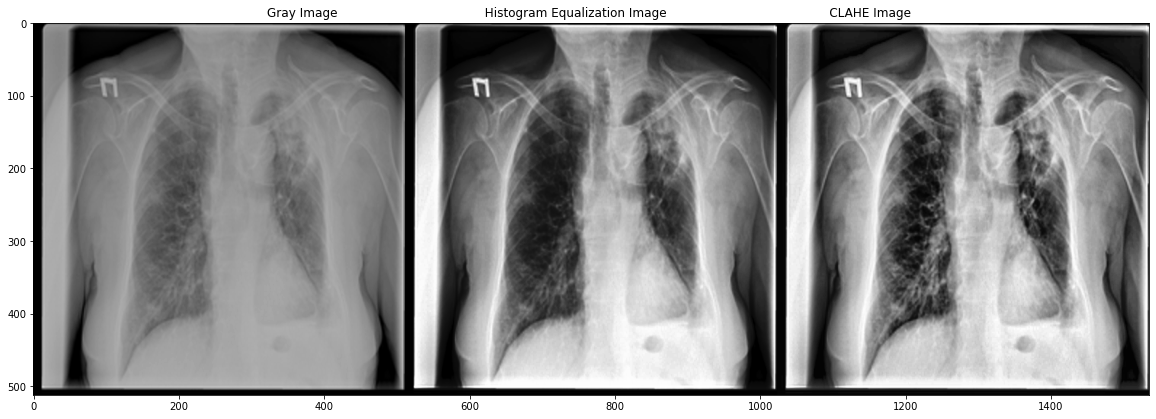

In [16]:
# Contrast Limited Adaptive Histogram Equalization for infected with TB chest
clahe2 = cv2.createCLAHE(clipLimit=3).apply(img_eqhist2)
images = np.concatenate((img2, img_eqhist2, clahe2),axis=1)
plt.figure(figsize=(20,20))
plt.imshow(images,cmap="gray")
plt.title('Gray Image                                      Histogram Equalization Image                                          CLAHE Image ')
plt.show()

As we can see the CLAHE function gives us a better result and its highlights the lymph nodes that the normal Histogram Equalization obliterated.

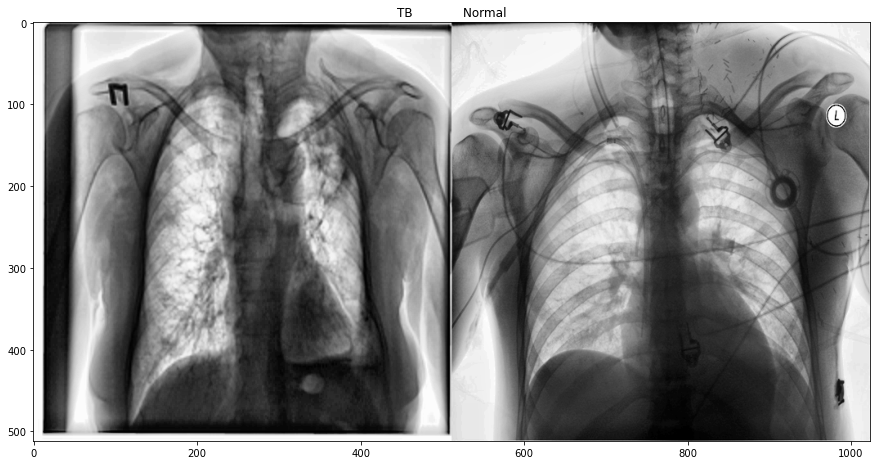

In [17]:
# inverting the image 
invert = cv2.bitwise_not(clahe)
invert2= cv2.bitwise_not(clahe2)
images = np.concatenate(( invert2,invert),axis=1)
plt.figure(figsize=(15,15))
plt.imshow(images,cmap="gray")
plt.title('TB             Normal')
plt.show()

next step we are going to apply CLAHE for all images and then useing vgg16 pretrained model we will classify the images to binary class healthy chest or infected with tuberculosis

## Classification model

In [18]:
import glob

In [119]:
import random
from shutil import copyfile

In [30]:
from PIL import Image

In [79]:
parent_dir = './normal-xray-database/'
os.mkdir(parent_dir)

In [81]:
parent2_dir = './tb-xray-database/'
os.mkdir(parent2_dir)

In [82]:
# read all images and apply CLAHE for all normal images
count = 0
for img in glob.glob( normalpath + "*.png"):
    n = cv2.imread(img)
    n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
    img_eqhist = cv2.equalizeHist(n)
    clahe = cv2.createCLAHE(clipLimit=3).apply(img_eqhist)
    count +=1
    cv2.imwrite(str(parent_dir)+'normal'+str(count)+'.png',clahe)

In [83]:
# read all images (TB) and apply CLAHE for all TB images
count = 0
for img in glob.glob( tbpath + "*.png"):
    n = cv2.imread(img)
    n = cv2.cvtColor(n, cv2.COLOR_BGR2GRAY)
    img_eqhist = cv2.equalizeHist(n)
    clahe = cv2.createCLAHE(clipLimit=3).apply(img_eqhist)
    count +=1
    cv2.imwrite(str(parent2_dir)+'tb'+str(count)+'.png',clahe)

In [84]:
# make directories for storing training and test sets
try:
    parent_dir = './xray-database/'
    os.mkdir(parent_dir)
    training_path = os.path.join(parent_dir, "training")
    testing_path = os.path.join(parent_dir, "testing")
    os.mkdir(training_path)
    os.mkdir(testing_path)
    os.mkdir(os.path.join(training_path, "normal"))
    os.mkdir(os.path.join(training_path, "tb"))
    os.mkdir(os.path.join(testing_path, "normal"))
    os.mkdir(os.path.join(testing_path, "tb"))
except OSError:
    print("couldn't make it")
    pass

In [85]:
# split the data into training and test sets

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    path_list = os.listdir(SOURCE)# file names in SOURCE
    length = len(path_list)
    count = 0
    for file in random.sample(path_list, length):
        file_path = os.path.join(SOURCE, file)
        if (os.path.getsize(file_path) != 0):
            if (count < SPLIT_SIZE*length):
                copyfile(file_path, os.path.join(TRAINING, file))
                count+=1
            else:
                copyfile(file_path, os.path.join(TESTING, file))

parent_dir = './normal-xray-database/'
TRAINING_NORMAL_DIR = os.path.join(training_path, "normal")
TESTING_NORMAL_DIR = os.path.join(testing_path, "normal")
parent2_dir = './tb-xray-database/'
TRAINING_TB_DIR = os.path.join(training_path, "tb")
TESTING_TB_DIR = os.path.join(testing_path, "tb")

split_size = .7
split_data(parent_dir, TRAINING_NORMAL_DIR, TESTING_NORMAL_DIR, split_size)
split_data(parent2_dir, TRAINING_TB_DIR, TESTING_TB_DIR, split_size)

In [86]:
print(f"Number of images in the training Normal class = {len(os.listdir(TRAINING_NORMAL_DIR))}")
print(f"Number of images in the testing Normal class = {len(os.listdir(TESTING_NORMAL_DIR))}")
print(f"Number of images in the training TB class = {len(os.listdir(TRAINING_TB_DIR))}")
print(f"Number of images in the testing TB class = {len(os.listdir(TESTING_TB_DIR))}")

Number of images in the training Normal class = 2450
Number of images in the testing Normal class = 1050
Number of images in the training TB class = 490
Number of images in the testing TB class = 210


 #### why we used vgg16 model?

In [87]:
from keras.preprocessing.image import ImageDataGenerator

In [89]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [91]:
image_size = [512,512]

In [96]:
vgg = VGG16(input_shape = image_size + [3], include_top=False)

58900480/58889256 [==============================] - 96s 2us/step


In [111]:
from keras.layers import  Dense, Flatten

In [97]:
for layer in vgg.layers:
    layer.trainable = False

In [113]:
folders = glob.glob('./xray-database/training/*')
x = Flatten()(vgg.output)

In [114]:
prediction = Dense(len(folders), activation = 'softmax')(x)
# create a model object
model = Model(inputs = vgg.input, outputs = prediction)
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [115]:
model.compile(
  loss = 'categorical_crossentropy',
  optimizer = 'adam',
  metrics = ['accuracy'])

In [116]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('./xray-database/training',
                                                 target_size = (512, 512),
                                                 batch_size = 10,
                                                 class_mode = 'categorical')


test_set = test_datagen.flow_from_directory('./xray-database/testing',
                                            target_size = (512, 512),
                                            batch_size = 10,
                                            class_mode = 'categorical')

Found 2940 images belonging to 2 classes.
Found 1260 images belonging to 2 classes.


In [118]:
t = model.fit_generator(training_set,
                        validation_data = test_set,
                        epochs = 10,
                        steps_per_epoch = len(training_set),
                        validation_steps = len(test_set))

C:\Users\hp\AppData\Local\Temp/ipykernel_15792/1149578030.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  t = model.fit_generator(training_set,


Epoch 1/10
294/294 [==============================] - 2015s 7s/step - loss: 0.2468 - accuracy: 0.9592 - val_loss: 0.0380 - val_accuracy: 0.9913
Epoch 2/10
294/294 [==============================] - 1889s 6s/step - loss: 0.1519 - accuracy: 0.9776 - val_loss: 0.1269 - val_accuracy: 0.9778
Epoch 3/10
294/294 [==============================] - 1953s 7s/step - loss: 0.1339 - accuracy: 0.9816 - val_loss: 0.0399 - val_accuracy: 0.9881
Epoch 4/10
294/294 [==============================] - 1907s 6s/step - loss: 0.1399 - accuracy: 0.9789 - val_loss: 0.0739 - val_accuracy: 0.9849
Epoch 5/10
294/294 [==============================] - 1909s 6s/step - loss: 0.2431 - accuracy: 0.9776 - val_loss: 0.0266 - val_accuracy: 0.9960
Epoch 6/10
294/294 [==============================] - 2289s 8s/step - loss: 0.1085 - accuracy: 0.9901 - val_loss: 0.0511 - val_accuracy: 0.9921
Epoch 7/10
294/294 [==============================] - 2576s 9s/step - loss: 0.1150 - accuracy: 0.9895 - val_loss: 0.0284 - val_accuracy:

In [175]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [120]:
import tensorflow as tf
from keras.models import load_model

model.save('chest_xray_model.h5')

In [121]:
model = load_model('chest_xray_model.h5')

In [215]:
# predict number of tb test sample
x = [4,182,221,13,42,656,7,134,681,514]

for i in x:
    img_path = './xray-database/testing/tb/tb'+str(i)+'.png'
    img = image.load_img(img_path, target_size=(512, 512))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    result = int(features[0][0])
    if result == 0:
        print("Patient is Affected By Tuberculosis")
    else:
        print("x-ray chest is Normal")

Patient is Affected By Tuberculosis
Patient is Affected By Tuberculosis
Patient is Affected By Tuberculosis
Patient is Affected By Tuberculosis
Patient is Affected By Tuberculosis
Patient is Affected By Tuberculosis
x-ray chest is Normal
Patient is Affected By Tuberculosis
Patient is Affected By Tuberculosis
Patient is Affected By Tuberculosis


In [216]:
# predict number of the normal test sample
x = [84,318,2935,3500,54,1,5,141,135,932]

for i in x:
    img_path = './xray-database/testing/normal/normal'+str(i)+'.png'
    img = image.load_img(img_path, target_size=(512, 512))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    features = model.predict(x)
    result = int(features[0][0])
    
    if result == 0:
        print("Patient is Affected By Tuberculosis")
    else:
        print("x-ray chest is Normal")

x-ray chest is Normal
x-ray chest is Normal
x-ray chest is Normal
x-ray chest is Normal
x-ray chest is Normal
x-ray chest is Normal
x-ray chest is Normal
x-ray chest is Normal
x-ray chest is Normal
x-ray chest is Normal


## Conclusion